<a href="https://colab.research.google.com/github/marcelounb/BB/blob/master/ia_mobile_TF_many_categories_final5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import os
# from google.colab import files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf

# For Tokenizing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# For N-grams
from keras.preprocessing import text

# Abrindo o arquivo com todo o Dataset para treinamento

In [4]:
path = "/content/fulldataset.xlsx"

In [5]:
dataset = pd.read_excel(path, sheet_name=0, header=0, dtype={'score': np.int32})

dataset[dataset.columns[3]] = dataset[dataset.columns[3]].fillna('não se aplica')  # retirando os valores nulos

responsavel       = dataset[dataset.columns[0]].tolist()   # Responsável
natureza          = dataset[dataset.columns[1]].tolist()   # Natureza
classificacao     = dataset[dataset.columns[2]].tolist()   # Classificação
produtos_servicos = dataset[dataset.columns[3]].tolist()   # Produtos/Serviços
detalhamento      = dataset[dataset.columns[4]].tolist()   # Detalhamento
review            = dataset[dataset.columns[15]].tolist()  # review
score             = dataset[dataset.columns[16]].tolist()  # score

In [6]:
print(list(dataset.columns))

['Responsável', 'Natureza', 'Classificação', 'Produtos/Serviços', 'Detalhamento', 'Descrição do Problema', 'Produtos/Serviços 2', 'Detalhamento 2', 'Descrição do Problema 2', 'Produtos/Serviços 3', 'Detalhamento 3', 'Descrição do Problema 3', 'id', 'userName', 'userImage', 'review', 'score', 'thumbsUpCount', 'appVersion', 'date', 'reply', 'replyDate']


# Reduzindo o texto (retirando artigos, pontuacao e conjuncao 'e') - review_reduzida

In [7]:
def reduzir_texto(frases):
  frase = ''
  for item in frases.lower().split():
    if item not in ['a', 'o', 'as', 'os', 'da', 'do', 'das', 'dos', 'e', 'no', 'na', 'em', 'i']:  # retira os artigos e conjuncao 'e'
      if item[-1] in ['.', ',', '!', ';' ]:
        frase +=str(item[0:-1])+' '  # retira pontuacao
      else:
        frase +=str(item)+' '

  return frase[:-1]

In [8]:
review_reduzida = []
for item in review:
  review_reduzida.append(reduzir_texto(item))
print(review[0:5])
print(review_reduzida[0:5])

['Excelente', 'Muito bom', 'Não estou conseguindo fazer um cartão de crédito para mim Eu só quero Aff já tentei várias vezes fazer o cartão quando eu fui fazer mandou esperar treis dias aí quando eu fui abri o aplicativo para ver se foi aprovado , Táva mandando fazer tudo dinovo', 'Por mais que eu tente não consigo desbloquear o app para transferências', 'Bom aplicativo eu gosto']
['excelente', 'muito bom', 'não estou conseguindo fazer um cartão de crédito para mim eu só quero aff já tentei várias vezes fazer cartão quando eu fui fazer mandou esperar treis dias aí quando eu fui abri aplicativo para ver se foi aprovado  táva mandando fazer tudo dinovo', 'por mais que eu tente não consigo desbloquear app para transferências', 'bom aplicativo eu gosto']


# Separando as bases de treinamento e de testes
Utilize review ou review_reduzida


In [9]:
def dataset_split(dataset_name, training_size):
  return dataset_name[0:training_size], dataset_name[training_size:]

training_size = int(len(review) * 0.8)  # Separate out the sentences and labels into training and test sets

training_sentences, testing_sentences = dataset_split(review_reduzida, training_size)  # Utilize review ou review_reduzida
training_labels, testing_labels = dataset_split(classificacao, training_size)  # Aqui - Dataset Escolhido
training_score,  testing_score = dataset_split(score, training_size)

In [10]:
def acrescentando_dimensionalidade(listagem):
  lista2 = []
  for item in listagem:
    lista3 = []
    lista3.append(item)
    lista2.append(lista3)
  return lista2

In [11]:
print(training_score[0:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [12]:
training_score = acrescentando_dimensionalidade(training_score)  # Acrescentando dimensionalidade a coluna Score
testing_score = acrescentando_dimensionalidade(testing_score)    # Acrescentando dimensionalidade a coluna Score

In [13]:
print(training_score[0:10])

[[1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]


In [14]:
# Tokenizing classificacao
tokenizer = Tokenizer(split='@', filters='@')  # Não categoriza novas palavras por causa de espaço ou caracteres especiais
tokenizer.fit_on_texts(classificacao)  # Aqui - Dataset Escolhido
word_index = tokenizer.word_index
print(word_index)
prediction_classes = word_index
reversed_prediction_classes = {value : key[0].upper() + key[1:] for (key, value) in prediction_classes.items()}
print(reversed_prediction_classes)

{'elogio': 1, 'reclamação': 2, 'crítica': 3, 'neutra': 4, 'dúvida': 5, 'sugestão': 6, 'resposta': 7, 'solicitação': 8}
{1: 'Elogio', 2: 'Reclamação', 3: 'Crítica', 4: 'Neutra', 5: 'Dúvida', 6: 'Sugestão', 7: 'Resposta', 8: 'Solicitação'}


In [15]:
len(word_index)
tamanho_classes = len(word_index)+1

In [16]:
def transforming_labels(lista):
  temp = []
  for item in lista:
    temp.append(word_index.get(item.lower()))
  return temp

In [17]:
training_labels[0:10]

['Elogio',
 'Elogio',
 'Reclamação',
 'Reclamação',
 'Elogio',
 'Reclamação',
 'Reclamação',
 'Reclamação',
 'Reclamação',
 'Reclamação']

In [18]:
training_labels = transforming_labels(training_labels)
testing_labels = transforming_labels(testing_labels)
training_labels[0:20]

[1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 3, 2, 2, 1, 2]

In [19]:
# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)
training_labels_final

array([1, 1, 2, ..., 1, 1, 1])

In [20]:
print(training_sentences[0:5])
print(training_labels[0:20], testing_labels[0:20])

['excelente', 'muito bom', 'não estou conseguindo fazer um cartão de crédito para mim eu só quero aff já tentei várias vezes fazer cartão quando eu fui fazer mandou esperar treis dias aí quando eu fui abri aplicativo para ver se foi aprovado  táva mandando fazer tudo dinovo', 'por mais que eu tente não consigo desbloquear app para transferências', 'bom aplicativo eu gosto']
[1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 3, 2, 2, 1, 2] [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2]


# Tokenize the dataset
Tokenize the dataset

In [21]:
# Tokenizing values
vocab_size = 4000
embedding_dim = 16
max_length = 150
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
sequences = tokenizer.texts_to_sequences(training_sentences)
word_index = tokenizer.word_index

N-grams (bigrams or trigrams)

In [22]:
def create_ngram_set(input_list, ngram_value=2):
    """Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]"""

    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]"""
    
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

In [23]:
# N-grams values
NGRAN_RANGE = 2

In [24]:
if NGRAN_RANGE > 1:
    ngram_set = set()
    for input_list in sequences:
        for i in range(2, NGRAN_RANGE + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)
    
    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.        
    token_indice = {v: k + vocab_size for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}
    
    # Update vocab_size
    vocab_size = np.max(list(indice_token.keys())) + 1
    print('Update vocab_size %d' % vocab_size)
    
    # Augument sequences with the new features
    sequences = add_ngram(sequences, token_indice, NGRAN_RANGE)
    print(len(sequences), 'sequences')
    print('Average train sequence length: %d' % np.mean(list(map(len, sequences))))

Update vocab_size 101154
66064 sequences
Average train sequence length: 12


Padding

In [25]:
trunc_type='post'
padding_type='post'

padded = pad_sequences(sequences,maxlen=max_length, padding=padding_type, truncating=trunc_type)  #review de treinamento com padding
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, padding=padding_type, truncating=trunc_type)  #review de treinamento com padding

In [26]:
print(padded.shape, testing_padded.shape)

(66064, 150) (16516, 150)


In [27]:
print(padded[0], '\n', training_score[0:4])

[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0] 
 [[1], [1], [1], [1]]


In [28]:
print(len(training_score), len(testing_score))

66064 16516


In [29]:
type(training_score)

list

In [30]:
training_score = np.asarray(training_score)
testing_score = np.asarray(testing_score)
print(type(training_score), type(testing_score))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Unindo o Dataset Score ao Dataset_escolhido (Natureza, Produto e Serviço ou Classificação)

In [31]:
padded2 = np.append(training_score, padded, axis=1)

In [32]:
testing_padded2 = np.append(testing_score, testing_padded, axis=1)

# Review a Sequence
Let's quickly take a look at one of the padded sequences to ensure everything above worked appropriately.

In [33]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, 'x') for i in text])

print(decode_review(padded[0]))
print(training_sentences[0])

excelente x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x
excelente


# Train a Basic Sentiment Model with Embeddings

In [34]:
max_length +=1  # Somando 1 do Score

In [35]:
# Build a basic sentiment network
# Note the embedding layer is first, 
# and the output is only 1 node as it is either 0 or 1 (negative or positive)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2001, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(501, activation='relu'),
    tf.keras.layers.Dense(51, activation='relu'),
    tf.keras.layers.Dense(tamanho_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'] )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 151, 16)           1618464   
_________________________________________________________________
flatten (Flatten)            (None, 2416)              0         
_________________________________________________________________
dense (Dense)                (None, 2001)              4836417   
_________________________________________________________________
dropout (Dropout)            (None, 2001)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 501)               1003002   
_________________________________________________________________
dense_2 (Dense)              (None, 51)                25602     
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 4

In [36]:
num_epochs = 4
hist = model.fit(padded2, training_labels_final, epochs=num_epochs, validation_data=(testing_padded2, testing_labels_final))

Epoch 1/4
2065/2065 [==============================] - 31s 15ms/step - loss: 0.1944 - accuracy: 0.9450 - val_loss: 0.1737 - val_accuracy: 0.9513
Epoch 2/4
2065/2065 [==============================] - 31s 15ms/step - loss: 0.0847 - accuracy: 0.9735 - val_loss: 0.1784 - val_accuracy: 0.9470
Epoch 3/4
2065/2065 [==============================] - 31s 15ms/step - loss: 0.0363 - accuracy: 0.9894 - val_loss: 0.2142 - val_accuracy: 0.9368
Epoch 4/4
2065/2065 [==============================] - 31s 15ms/step - loss: 0.0221 - accuracy: 0.9938 - val_loss: 0.2281 - val_accuracy: 0.9390


In [37]:
scores = model.evaluate(testing_padded2, testing_labels_final, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
print(hist.history.keys())

Baseline Error: 6.10%
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


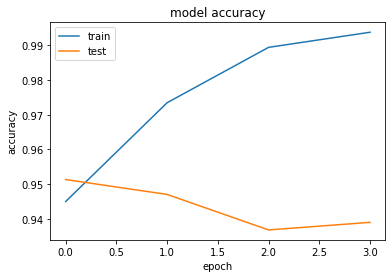

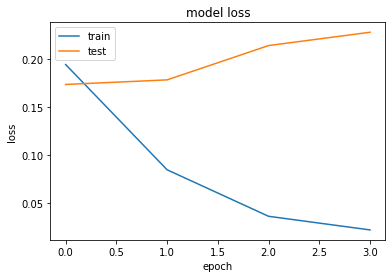

In [38]:
plt.plot(hist.history[ 'accuracy' ])
plt.plot(hist.history[ 'val_accuracy' ])
plt.title( 'model accuracy' )
plt.ylabel( 'accuracy')
plt.xlabel( 'epoch' )
plt.legend([ 'train' , 'test' ], loc= 'upper left' )
plt.show()
# summarize history for loss
plt.plot(hist.history[ 'loss' ])
plt.plot(hist.history[ 'val_loss' ])
plt.title( 'model loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend([ 'train' , 'test' ], loc= 'upper left' )
plt.show()

# Novas Predições:

In [39]:
path = "/content/novoarquivo.xlsx"

In [40]:
dataset = pd.read_excel(path, sheet_name=0, header=0, dtype={'score': np.int32})

responsavel       = dataset[dataset.columns[0]].tolist()   # Responsável
natureza          = dataset[dataset.columns[1]].tolist()   # Natureza
classificacao     = dataset[dataset.columns[2]].tolist()   # Classificação
produtos_servicos = dataset[dataset.columns[3]].tolist()   # Produtos/Serviços
detalhamento      = dataset[dataset.columns[4]].tolist()   # Detalhamento
review            = dataset[dataset.columns[15]].tolist()  # review
score             = dataset[dataset.columns[16]].tolist()  # score

In [41]:
# Use the model to predict a review   
new_reviews = review

print(new_reviews) 

max_length = 150
# Create the sequences
new_sequences = tokenizer.texts_to_sequences(new_reviews)

['muito útil pra mim.', '👍', 'O aplicativo tem muito a melhor, pois as vezes acontece uns bugs, trava.', 'regular', 'ótimo app', 'O melhor App, melhor banco!', 'gostei muito', 'muito bom gostei.', 'prático', 'excelente!', 'o app é bom', 'eletrodo 051 poupança orurcard 00', 'Melhor App do setor bancário. Intuitivo, leve e sempre funciona. Sou fã', 'bom', 'Gostei do APP, bem funcional e fácil de utilizar.', 'muita útil', 'Excelente.', 'o banco com muita competência,e principalmente quero elogiar funcionário Alex sempre que eu vou na minha agência me trata super bem', 'otimo', 'parabenizo ao banco do brasil pela assistência aos seus clientes. e o aplicativo e ótimo', 'simplesmente maravilhoso.', 'Excelente apkicativo', 'muito bom .. facilita demais', 'Aplicativo sem nenhuma crítica a fazer. Só elogio.', 'recomendo', 'muito bom', 'As restrições de valores mas transações praticamente inviabiliza agilidade e efetividade no dia a dia. Vou reduzir o movimento nesta conta e movimentar em outros

In [42]:
if NGRAN_RANGE > 1:
  temp_list_final = []
  for item in new_sequences:
    # print(item)
    temp_list, temp_list2 = [], []
    for each in item:
      # print('--', each)
      if len(temp_list)==0:
        primeiro_item = each  # Primeira vez que passa
        temp_list.append(each)
      else:
        tupla = (primeiro_item, each)
        if token_indice.get(tupla) is not None:
          temp_list2.append(token_indice.get(tupla))
        temp_list.append(each)
        primeiro_item = each
    temp_list = temp_list + temp_list2
    temp_list_final.append(temp_list)
    # print(temp_list)
  print(temp_list_final)
  new_sequences = temp_list_final

[[2, 75, 28, 102, 97216, 9657, 31829], [244], [488, 6, 32, 2, 647, 21, 115, 2141, 146, 751, 613, 720, 206, 98655, 48153, 14578, 52190, 45997, 44908, 7702, 87518], [1164], [7, 5, 52186], [488, 21, 5, 21, 14, 79098, 68920, 36234, 59863], [46, 2, 52468], [2, 3, 46, 31563, 65150], [12], [10], [488, 5, 11, 3, 86083, 71926, 74106], [1, 1, 272, 1, 626, 75745, 80393, 51388, 54283], [21, 5, 2009, 1993, 383, 101, 394, 226, 50, 85, 152, 1649, 68920, 47259, 40634, 62967, 70467, 85825, 48521, 17941], [3], [46, 2009, 5, 22, 97, 226, 13, 4, 174, 23677, 86257, 8816, 48827, 20135, 73523], [141, 75], [10], [488, 14, 16, 141, 3322, 226, 255, 209, 1722, 1225, 1, 50, 8, 23, 124, 2105, 24, 82, 30, 2292, 74, 22, 5073, 33255, 79169, 72638, 9839, 25683, 56135, 20536, 80577, 38813, 60414, 85334, 86497, 28552], [40], [2765, 55, 14, 2009, 66, 252, 2331, 264, 497, 311, 226, 488, 6, 226, 7, 66392, 88860, 72963, 39941, 75018, 56005, 98655, 35990, 27039], [248, 113, 35406], [10, 1, 21038], [2, 3, 63, 137, 31563, 4553

In [43]:
predict_padded = pad_sequences(new_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [44]:
score = acrescentando_dimensionalidade(score)
score = np.asarray(score)

In [45]:
predict_padded2 = np.append(score, predict_padded, axis=1)

In [46]:
predict_padded2.shape

(783, 151)

In [47]:
print('\n Exemplo de nova prediçao\n')              

classes = model.predict(predict_padded2)

print(new_reviews[17])
print(classes[15:17])


 Exemplo de nova prediçao

o banco com muita competência,e principalmente quero elogiar funcionário Alex sempre que eu vou na minha agência me trata super bem
[[7.8808401e-12 9.8079199e-01 4.8071687e-04 5.2859850e-04 1.6828338e-02
  1.0266672e-05 4.4042208e-05 1.3121573e-03 3.8744961e-06]
 [2.5114315e-22 9.9999607e-01 1.1528161e-06 2.2024827e-07 2.2808877e-06
  7.1873493e-11 2.6238647e-09 2.2894291e-07 1.0648620e-11]]


In [48]:
type(predict_padded)

numpy.ndarray

In [49]:
classes_list = classes.tolist()
for contagem in range(10):
  print(contagem, classes_list[contagem].index(np.max(classes[contagem], axis=0, keepdims=True)))

0 1
1 1
2 2
3 4
4 1
5 1
6 1
7 1
8 1
9 1


In [50]:
print(reversed_prediction_classes, '\n', reversed_prediction_classes[2] )

{1: 'Elogio', 2: 'Reclamação', 3: 'Crítica', 4: 'Neutra', 5: 'Dúvida', 6: 'Sugestão', 7: 'Resposta', 8: 'Solicitação'} 
 Reclamação


In [51]:
lista_predicao = []
for item in classes_list:
  lista_predicao.append(reversed_prediction_classes[item.index(max(item))])
lista_predicao[5]

'Elogio'

In [52]:
dataset[dataset.columns[2]] = lista_predicao
dataset.head(3)

,Responsável,Natureza,Classificação,Produtos/Serviços,Detalhamento,Descrição do Problema,Produtos/Serviços 2,Detalhamento 2,Descrição do Problema 2,Produtos/Serviços 3,Detalhamento 3,Descrição do Problema 3,id,userName,userImage,review,score,thumbsUpCount,appVersion,date,reply,replyDate
0,Automático,Opinião,Elogio,Aplicativo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gp:AOqpTOGg0Ev4vB_osA6Vwgrw3LwwPgWNswzhCMkxbIt...,Ketlley Rose,https://play-lh.googleusercontent.com/a-/AOh14...,muito útil pra mim.,4,0,7.29.2.0,2020-10-26 09:28:38,NaN,NaT
1,Rossato,Opinião,Elogio,Aplicativo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gp:AOqpTOGJpbBxSAVeEexyJCkSou2OFbdAUhTK4O5KCsD...,Gabriel Pinheiro,https://play-lh.googleusercontent.com/-pwSaK9q...,👍,5,0,7.29.2.0,2020-10-26 09:25:37,NaN,NaT
2,Automático,Técnica,Reclamação,Aplicativo,Disponibilidade/Estabilidade,Travamento,NaN,NaN,NaN,NaN,NaN,NaN,gp:AOqpTOHBKSLCpLKrgAY04-Vd2pX5b-xyDpQTxuV0XBd...,jose lucas,https://play-lh.googleusercontent.com/a-/AOh14...,"O aplicativo tem muito a melhor, pois as vezes...",3,0,7.29.2.0,2020-10-26 09:22:47,"Oi! Li seu comentário, mas não consegui entend...",2020-10-26 08:19:19


# Salvando o arquivo em Excel

In [53]:
writer = pd.ExcelWriter("predicao_gerada.xlsx")
dataset.to_excel(writer, index=False)
writer.save()